# Recommendation System (Market Basket Analysis) - Instacart

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
#Import datasets
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products_prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [3]:
#Merging datasets
df_a = pd.merge(products, aisles, on = 'aisle_id')
df_b = pd.merge(df_a, departments, on = 'department_id')
df_b = df_b.drop(columns = ['aisle_id','department_id'])
df_c = pd.merge(df_b, order_products_prior, on = 'product_id')
df_d = pd.merge(df_c, orders, on = 'order_id')

In [2]:
#df_comp = pd.read_csv('complete.csv')
#df = df_comp.drop(columns = ['Unnamed: 0'])
#df1 = df.copy()

### Exploratory Data Analysis

In [18]:
# Changing type of the variables
df1["order_dow"] = df1["order_dow"].astype('category')
df1["reordered"] = df1["reordered"].astype('category')

#Replace NAs values as "-1"
df1["days_since_prior_order"].fillna(-1, inplace=True)
df1["days_since_prior_order"] = df1["days_since_prior_order"].astype('int64')

### Data analysis with charts

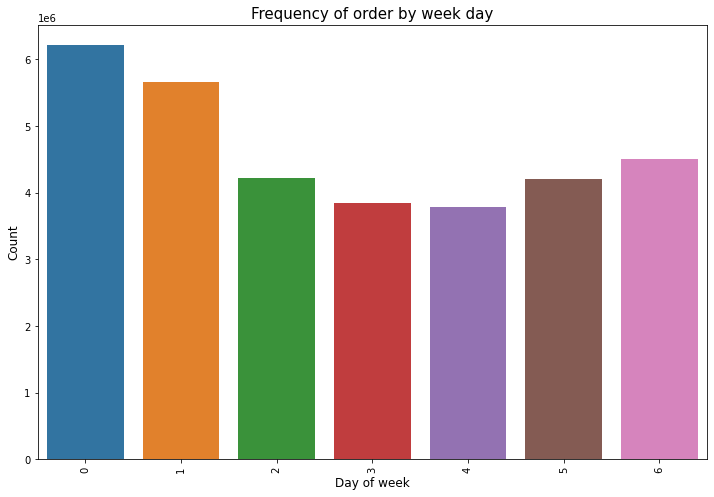

In [13]:
#Frequency of order by week day
#It was considered that 0 and 1 represents the weekends due to most values are represented by these numbers
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=df_comp)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

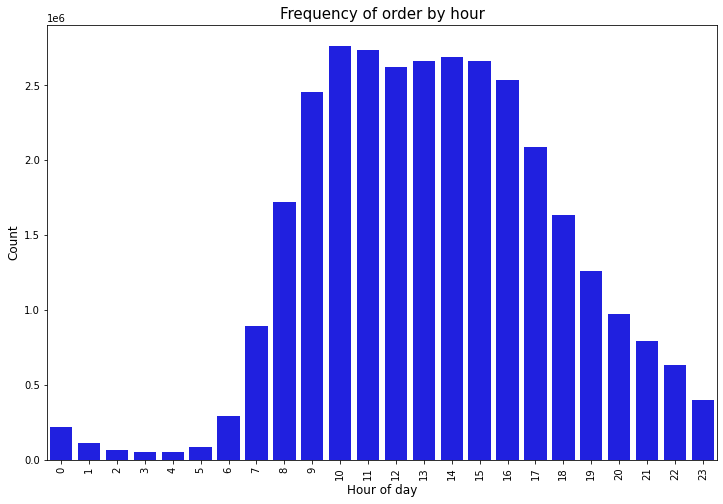

In [16]:
#Frequency of order by hour
#In this chart we can visualize that the most orders hours are during 9AM to 4PM
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=df_comp, color = 'b')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour", fontsize=15)
plt.show()

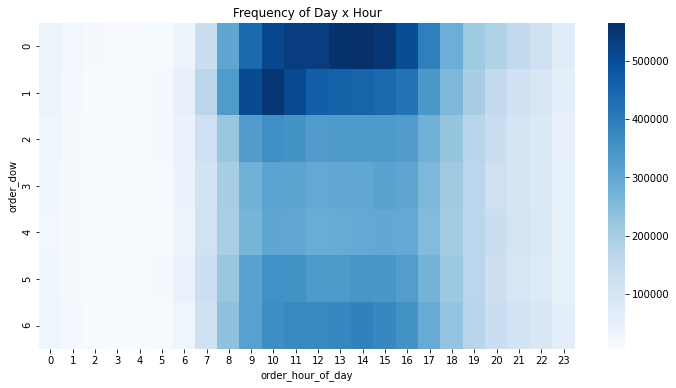

In [19]:
#Frequency of Day x Hour
#In this chart we can verify which hour and day have more orders. Weekdays at 10-15h have more orders

grouped_df = df_comp.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap="Blues")
plt.title("Frequency of Day x Hour")
plt.show()

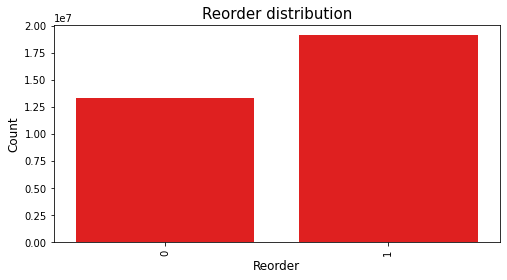

In [40]:
#Reorder distribution
plt.figure(figsize=(8,4))
sns.countplot(x="reordered", data=df_comp, color = 'r')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Reorder', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Reorder distribution", fontsize=15)
plt.show()

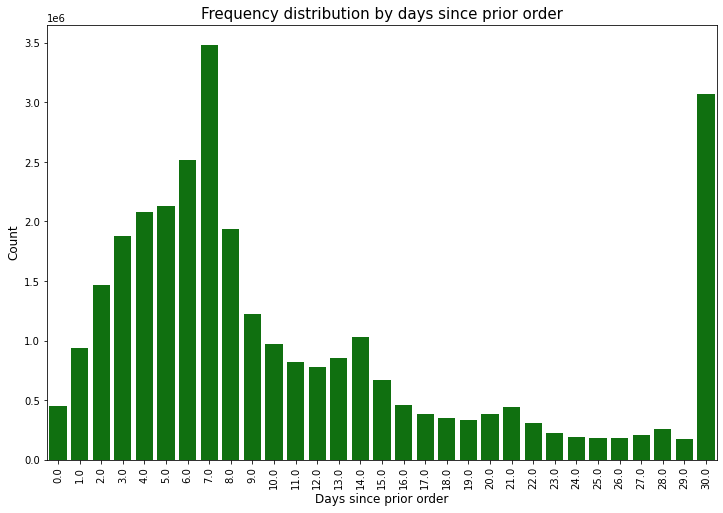

In [22]:
#Frequency distribution by days since prior order
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=df_comp, color = 'green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

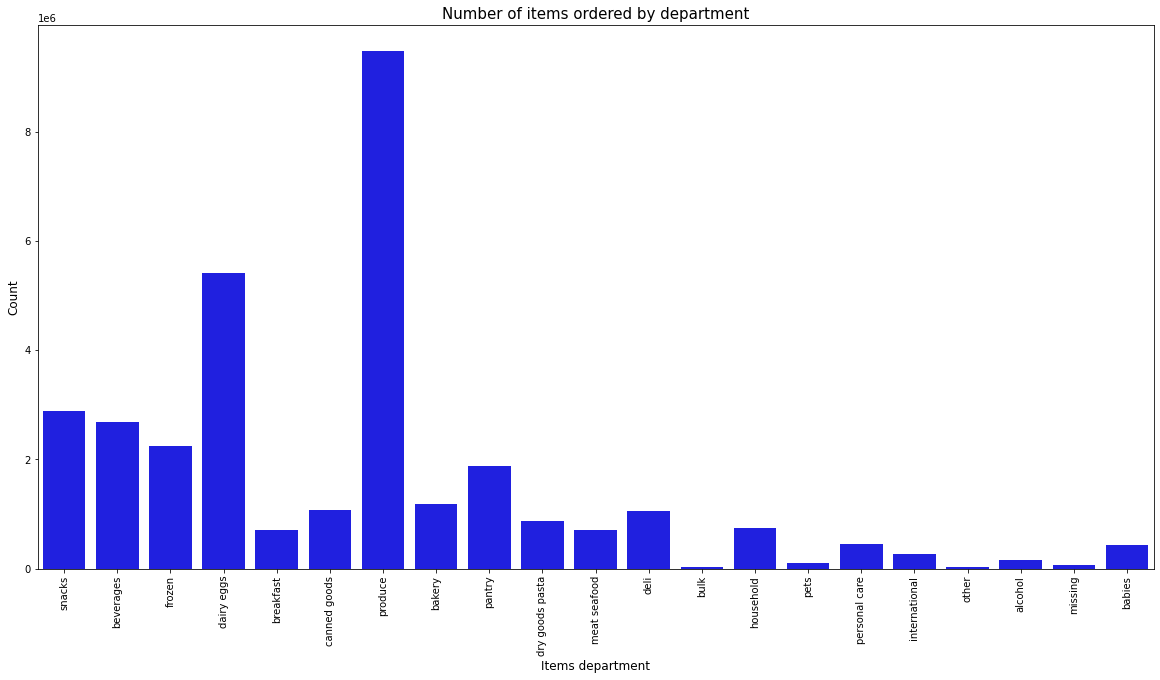

In [25]:
#Number of items ordered by department
plt.figure(figsize=(20,10))
sns.countplot(x="department", data=df_comp, color = 'blue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Items department', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Number of items ordered by department", fontsize=15)
plt.show()

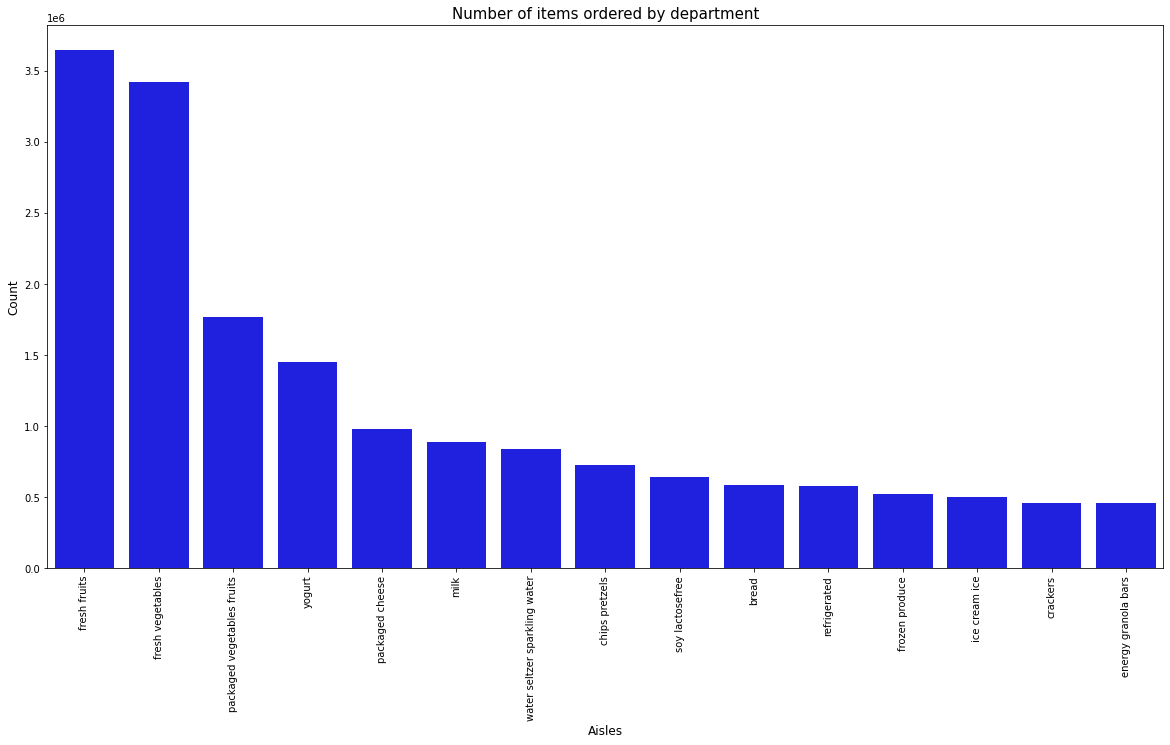

In [31]:
#Number of items ordered by department
aisle_15 = df_comp['aisle'].value_counts().head(15)
plt.figure(figsize=(20,10))
sns.barplot(aisle_15.index, aisle_15.values, color = 'blue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Aisles', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Order by aisles", fontsize=15)
plt.show()

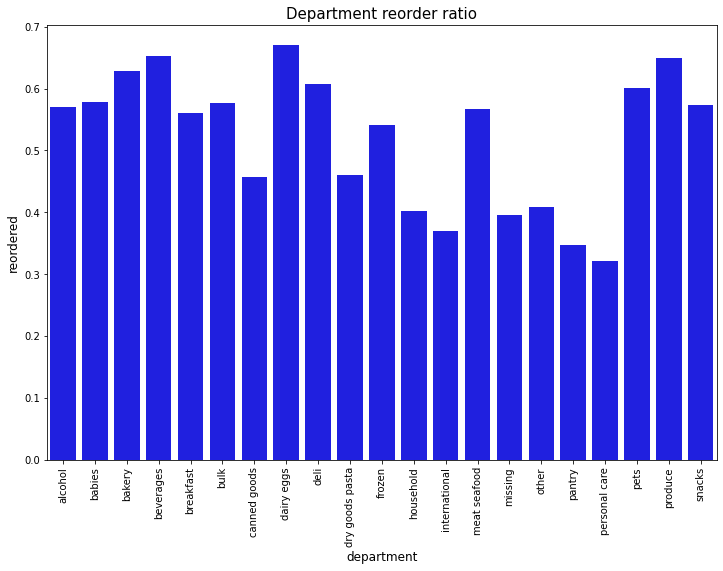

In [11]:
# Department reorder ratio
g_df = df_comp.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(g_df["department"].values, g_df["reordered"].values, color = 'blue')
plt.ylabel('reordered', fontsize=12)
plt.xlabel('department', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Department reorder ratio", fontsize=15)
plt.show()

In [ ]:
#Using 10% of the data to facilitate the analysis
df1_y = df1['reordered']
df1_x = df1.drop(['reordered'], axis=1)
dfx_10, dfx_rest, dfy_10, dfy_rest = train_test_split(df1_x, df1_y, train_size=0.1)
df_10 = pd.concat([dfx_10, dfy_10], axis=1)

In [38]:
df_10.head()

,product_name,aisle,department,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
3833213,Apple Pie Fruit & Nut Food Bar,energy granola bars,snacks,2,47451,41,1,12,0,1
28402391,Grilled Chicken Breast,prepared meals,deli,5,165485,13,0,17,24,1
1608296,1% Low Fat Milk,milk,dairy eggs,1,182595,61,3,9,6,1
13905990,Organic Zucchini,fresh vegetables,produce,8,154148,20,1,15,8,1
14370689,Organic Black Pepper,crackers,snacks,1,45564,5,1,23,13,0


In [20]:
#Products more frequents
cnt_srs = df_10['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,47280
1,Bag of Organic Bananas,37808
2,Organic Strawberries,26702
3,Organic Baby Spinach,24180
4,Organic Hass Avocado,21560
5,Organic Avocado,17766
6,Large Lemon,15289
7,Strawberries,14313
8,Limes,14168
9,Organic Whole Milk,13722


In [24]:
order_products_prior.product_id.nunique()

49677

Filtering 100 most frequent products

In [27]:
most_freq_prod = order_products_prior.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
most_freq_prod = most_freq_prod.sort_values('frequency', ascending=False)[0:100].reset_index(drop = True)
most_freq_prod = most_freq_prod.merge(products, on = 'product_id', how = 'left')
most_freq_prod.head(10)

In [35]:
freq_products = list(most_freq_prod.product_id)
order_products_2 = order_products_prior[order_products_prior.product_id.isin(freq_products)]
order_products_2 = order_products_2.merge(products, on = 'product_id', how='left')
order_products_2.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,28985,2,1,Michigan Organic Kale,83,4
1,2,17794,6,1,Carrots,83,4
2,3,24838,2,1,Unsweetened Almondmilk,91,16
3,3,21903,4,1,Organic Baby Spinach,123,4
4,3,46667,6,1,Organic Ginger Root,83,4


In [36]:
#Encoding list of products
basket = order_products_2.groupby(['order_id', 'product_name'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
basket = basket.applymap(encode_units)
basket.head()

product_name,100% Raw Coconut Water,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Bartlett Pears,Blueberries,Boneless Skinless Chicken Breasts,...,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsalted Butter,Unsweetened Almondmilk,Unsweetened Original Almond Breeze Almond Milk,Whole Milk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
#Creating frequent sets and rules
frequent_items = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)
frequent_items.head()

,support,itemsets
0,0.016150,(100% Raw Coconut Water)
1,0.025866,(100% Whole Wheat Bread)
2,0.015775,(2% Reduced Fat Milk)
3,0.036160,(Apple Honeycrisp Organic)
4,0.028616,(Asparagus)


In [44]:
#List of Market Basket Analysis
list_MBA = association_rules(frequent_items, metric="lift", min_threshold=1)
list_MBA.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
36,(Large Lemon),(Limes),0.064926,0.059810,0.011655,0.179507,3.001302,0.007771,1.145885
37,(Limes),(Large Lemon),0.059810,0.064926,0.011655,0.194863,3.001302,0.007771,1.161385
55,(Organic Strawberries),(Organic Raspberries),0.112572,0.058291,0.014402,0.127938,2.194801,0.007840,1.079864
54,(Organic Raspberries),(Organic Strawberries),0.058291,0.112572,0.014402,0.247072,2.194801,0.007840,1.178637
39,(Organic Avocado),(Large Lemon),0.075201,0.064926,0.010385,0.138093,2.126931,0.005502,1.084890
38,(Large Lemon),(Organic Avocado),0.064926,0.075201,0.010385,0.159947,2.126931,0.005502,1.100882
49,(Organic Strawberries),(Organic Blueberries),0.112572,0.042556,0.010104,0.089753,2.109035,0.005313,1.051850
48,(Organic Blueberries),(Organic Strawberries),0.042556,0.112572,0.010104,0.237418,2.109035,0.005313,1.163715
51,(Organic Hass Avocado),(Organic Raspberries),0.090839,0.058291,0.010970,0.120763,2.071710,0.005675,1.071052
50,(Organic Raspberries),(Organic Hass Avocado),0.058291,0.090839,0.010970,0.188192,2.071710,0.005675,1.119921


3 important information are presented in the table "list_MBA":

1. Confidence: refers to the likelihood that an item B is also bought if item A is bought.

    *Example* - The likelihood of buying Limes when a Large Lemon is 18%

2. Support: refers to the default popularity of an item and can be calculated by finding number of transactions containing a particular item divided by total number of transactions.

    *Example* - Buying Limes represents 1.17% of all dataset

3. Lift: refers to the increase in the ratio of sale of B when A is sold.

- Lift of 1 means there is no association between products A and B.

- Lift of greater than 1 means products A and B are more likely to be bought together.

- Lift of less than 1 refers to the case where two products are unlikely to be bought together.

    *Example* - The likelihood of buying Limes and Large Lemon together is 3 times more than the likelihood of just buying the Large Lemon

### Data analysis

In [2]:
#Using 10% of the data
df_10 = pd.read_csv('resumido.csv')
df_10 = df_10.drop(columns = ['Unnamed: 0'])

In [3]:
# Changing type of the variables
df_10["order_dow"] = df_10["order_dow"].astype('category')
df_10["reordered"] = df_10["reordered"].astype('category')

#Replace NAs values as "-1"
df_10["days_since_prior_order"].fillna(-1, inplace=True)
df_10["days_since_prior_order"] = df_10["days_since_prior_order"].astype('int64')


df_10["department"] = df_10["department"].astype('category')
df_10["department"] = df_10["department"].cat.codes
df_10["department"] = df_10["department"].astype('category')

df_10["aisle"] = df_10["aisle"].astype('category')
df_10["aisle"] = df_10["aisle"].cat.codes
df_10["aisle"] = df_10["aisle"].astype('category')

In [7]:
df_10.head()

,product_name,aisle,department,add_to_cart_order,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,Apple Pie Fruit & Nut Food Bar,42,20,2,47451,41,1,12,0,1
1,Grilled Chicken Breast,105,8,5,165485,13,0,17,24,1
2,1% Low Fat Milk,83,7,1,182595,61,3,9,6,1
3,Organic Zucchini,53,19,8,154148,20,1,15,8,1
4,Organic Black Pepper,32,20,1,45564,5,1,23,13,0


In [8]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3243448 entries, 0 to 3243447
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   product_name            object  
 1   aisle                   category
 2   department              category
 3   add_to_cart_order       int64   
 4   user_id                 int64   
 5   order_number            int64   
 6   order_dow               category
 7   order_hour_of_day       int64   
 8   days_since_prior_order  int64   
 9   reordered               category
dtypes: category(4), int64(5), object(1)
memory usage: 163.9+ MB


## Feature Selection - Variables with DecisionTreeRegressor

In [27]:
tree = DecisionTreeRegressor().fit(df_10_x, df_10_y)
tree.feature_importances_

array([0.05324338, 0.03879009, 0.08879717, 0.27513323, 0.24908707,
       0.07751557, 0.1209466 , 0.0964869 ])

According to Decision Tree Regressor, we'll remove *product_name* and *aisle* variables

In [4]:
#Separate in train and test data
df_10_y = df_10['reordered']
df_10_x = df_10.drop(['reordered', 'product_name','aisle'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_10_x, df_10_y, train_size=0.3)

## Predictive Analysis

1) Logistic Regression

In [11]:
# Criando o objeto logistic regression 
modelo = LogisticRegression()

# Treinando o modelo com dados de treino e checando o score
modelo.fit(x_train, y_train)

# Previsões
valores_previstos = modelo.predict(x_test)
accuracy_score(valores_previstos, y_test)

0.6680645027735029

2) Gradient Boosting Classifier

In [14]:
# Criando o objeto Gradient Boosting 
modelo_v2 = GradientBoostingClassifier(n_estimators = 300, learning_rate = 1.0, max_depth = 1, random_state = 0)

# Treinando o modelo com dados de treino 
modelo_v2.fit(x_train, y_train)

# Previsões
valores_previstos_v2 = modelo_v2.predict(x_test)
accuracy_score(valores_previstos_v2, y_test)

0.7288102522271268

3) Random Forest Classifier

In [33]:
# Criando o objeto Random Forest 
modelo_v3 = RandomForestClassifier()

# Treinando o modelo com dados de treino 
modelo_v3.fit(x_train, y_train)

# Previsões
valores_previstos_v3 = modelo_v3.predict(x_test)
accuracy_score(valores_previstos_v3, y_test)

0.6812788328472252

### Conclusion

With the 3 models evaluated, we achieve 72,88% of accuracy using Gradient Boosting
This value was achieve with just 10% of total data. Maybe this value can be improved using all dataset.